# DataJam

En el siguiente Jupyter se encuentra todo el procesamiento de datos para su exposicion en la interfaz. 

## Librerias 

Las siguientes librerias nos permiten llevar a cabo de manera satisfactoria la lectura, limpieza y procesamiento de datos. 

In [60]:
from zipfile import ZipFile, ZIP_DEFLATED 
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import requests
import json
import re
import os

## Lectura del crudo

El conjunto de datos a trabajar esta contenido en el crudo **Parrilla_programacion_8.csv**. Por cuestiones de almacenamiento, se accede a este archivo por medio de un comprimido .ZIP **Parrilla_programacion_8.zip**. Inicialmente, se descomprime y se extrae nuestro objetivo. 

In [2]:
test_file_name = "Parrilla_programacion_8.zip"

with ZipFile(test_file_name, 'r') as zip:
    zip.printdir()
    zip.extractall()

File Name                                             Modified             Size
Parrilla_programacion_8.csv                    2022-07-09 15:53:06    230556275


Despues, se procede a la lectura del crudo para hacer la limpieza de los datos. 

In [3]:
df_original = pd.read_csv("Parrilla_programacion_8.csv", sep=";", engine = "python")

De esta manera, puedo observar nuestro DataFrame de datos:

In [4]:
df_original

,EMPRESA,ID_EMPRESA,TIPO_OPERADOR,ANNO,TRIMESTRE,FECHA,HORA_INICIO,HORA_FIN,DURACION,PROGRAMA,CLASIFICACION,GENERO,TIPO,CLOSED_CAPTION,LENGUA_SENAS,SUBTITULADO,LENGUAS_NATIVAS
0,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,00:00:33,00:28:33,00:28:00,HUELLAS DEL AMADO,FAMILIAR,NO FICCIÓN,EDUCATIVO,NINGUNO,NO,NO,NO
1,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,00:30:15,00:59:10,00:28:55,PLAN B,FAMILIAR,NO FICCIÓN,EDUCATIVO,NINGUNO,NO,NO,NO
2,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,01:00:14,02:28:14,01:28:00,DESDE EL PÚLPITO,FAMILIAR,NO FICCIÓN,PREDICACIÓN,NINGUNO,NO,NO,NO
3,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,02:30:15,03:29:15,00:59:00,MENSAJE DE ESPERANZA,FAMILIAR,NO FICCIÓN,PREDICACIÓN,NINGUNO,NO,NO,NO
4,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,03:30:14,03:58:14,00:28:00,EL PUEDE HACERLO DE NUEVO,FAMILIAR,NO FICCIÓN,PREDICACIÓN,NINGUNO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141286,Universidad del Valle,890399010,TV Sin Animo de Lucro - Local Abierta,2022,1,2022-03-31,20:30:00,21:00:00,00:30:00,Charlas con Aguayo,FAMILIAR,INFORMATIVO,OPINION REPORTAJES,NINGUNO,NO,NO,NO
1141287,Universidad del Valle,890399010,TV Sin Animo de Lucro - Local Abierta,2022,1,2022-03-31,21:00:00,22:00:00,01:00:00,En Contacto,FAMILIAR,INFORMATIVO,CULTURAL OPINIÓN,NINGUNO,NO,NO,NO
1141288,Universidad del Valle,890399010,TV Sin Animo de Lucro - Local Abierta,2022,1,2022-03-31,22:00:00,22:30:00,00:30:00,Entre Libros arte y cultura,FAMILIAR,INFORMATIVO,CULTURAL LITERATURA,NINGUNO,NO,NO,NO
1141289,Universidad del Valle,890399010,TV Sin Animo de Lucro - Local Abierta,2022,1,2022-03-31,22:30:00,23:00:00,00:30:00,Noti 5,FAMILIAR,INFORMATIVO,INFORMATIVO.,NINGUNO,NO,NO,NO


Ya con el .CSV cargado, se eliminaran caracteres en blanco que pueden generar problemas para el procesamiento de datos, y se realizara una estandarizacion del formato de los strings para evitar valores repetidos. 

In [35]:
df_lim = df_original.copy()
for column in df_lim.columns:
    df_lim[column] = df_lim[column].apply(lambda x: str(x).strip().title())

Posteriormente, se realizara una conversion a segundos de la duracion de cada emision para poder analizar esta variable. 

In [36]:
def get_sec(time_str):
    time = str(time_str)
    h, m, s = time.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

df_lim["DURACION"] = df_lim["DURACION"].apply(lambda x: x.replace("Nd", "00:00:00"))
df_lim["DURACION"] = df_lim["DURACION"].apply(get_sec)

Seguidamente, se agregara una nueva columna al conjunto de datos basada en la variable **HORA_INICIO** para determinar la **JORNADA** de emision de cada programa: 

In [37]:
def schedule(hora_inicio):
    try:
        hora = datetime.strptime(hora_inicio, "%H:%M:%S").time()
        if hora >= datetime.strptime("00:00:00", "%H:%M:%S").time() and hora < datetime.strptime("06:00:00", "%H:%M:%S").time():
            return "Madrugada"
        elif hora >= datetime.strptime("06:00:00", "%H:%M:%S").time() and hora < datetime.strptime("12:00:00", "%H:%M:%S").time():
            return "Mañana"
        elif hora >= datetime.strptime("12:00:00", "%H:%M:%S").time() and hora < datetime.strptime("18:00:00", "%H:%M:%S").time():
            return "Tarde"
        elif hora >= datetime.strptime("18:00:00", "%H:%M:%S").time() and hora < datetime.strptime("23:59:59", "%H:%M:%S").time():
            return "Noche"
    except:
        return "Nd"

In [38]:
df_lim["JORNADA"] = df_lim["HORA_INICIO"].apply(schedule)

Obteniendo asi este conjunto cada vez mas util:

In [39]:
df_lim

,EMPRESA,ID_EMPRESA,TIPO_OPERADOR,ANNO,TRIMESTRE,FECHA,HORA_INICIO,HORA_FIN,DURACION,PROGRAMA,CLASIFICACION,GENERO,TIPO,CLOSED_CAPTION,LENGUA_SENAS,SUBTITULADO,LENGUAS_NATIVAS,JORNADA
0,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,00:00:33,00:28:33,1680,Huellas Del Amado,Familiar,No Ficción,Educativo,Ninguno,No,No,No,Madrugada
1,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,00:30:15,00:59:10,1735,Plan B,Familiar,No Ficción,Educativo,Ninguno,No,No,No,Madrugada
2,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,01:00:14,02:28:14,5280,Desde El Púlpito,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada
3,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,02:30:15,03:29:15,3540,Mensaje De Esperanza,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada
4,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,03:30:14,03:58:14,1680,El Puede Hacerlo De Nuevo,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141286,Universidad Del Valle,890399010,Tv Sin Animo De Lucro - Local Abierta,2022,1,2022-03-31,20:30:00,21:00:00,1800,Charlas Con Aguayo,Familiar,Informativo,Opinion Reportajes,Ninguno,No,No,No,Noche
1141287,Universidad Del Valle,890399010,Tv Sin Animo De Lucro - Local Abierta,2022,1,2022-03-31,21:00:00,22:00:00,3600,En Contacto,Familiar,Informativo,Cultural Opinión,Ninguno,No,No,No,Noche
1141288,Universidad Del Valle,890399010,Tv Sin Animo De Lucro - Local Abierta,2022,1,2022-03-31,22:00:00,22:30:00,1800,Entre Libros Arte Y Cultura,Familiar,Informativo,Cultural Literatura,Ninguno,No,No,No,Noche
1141289,Universidad Del Valle,890399010,Tv Sin Animo De Lucro - Local Abierta,2022,1,2022-03-31,22:30:00,23:00:00,1800,Noti 5,Familiar,Informativo,Informativo.,Ninguno,No,No,No,Noche


Por ultimo, por cuestiones de procesamiento, se obviaran las emisiones menores a **cinco (5) minutos**, pues estan no son significativas para la estrategia. 

In [43]:
def priv(text):
    if re.search("Privada", text):
        return "Privada"
    else:
        return "No Privada"
def alcance(reg):
    if "Espacios" in reg:
        reg += " - Nacional "
    return re.findall("\s-\s(.*)\s", reg)[0]

In [44]:
df_lim["ACCESO"] = df_lim["TIPO_OPERADOR"].apply(priv)
df_lim["COBERTURA"] = df_lim["TIPO_OPERADOR"].apply(alcance)

In [45]:
df_lim

,EMPRESA,ID_EMPRESA,TIPO_OPERADOR,ANNO,TRIMESTRE,FECHA,HORA_INICIO,HORA_FIN,DURACION,PROGRAMA,CLASIFICACION,GENERO,TIPO,CLOSED_CAPTION,LENGUA_SENAS,SUBTITULADO,LENGUAS_NATIVAS,JORNADA,ACCESO,COBERTURA
0,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,00:00:33,00:28:33,1680,Huellas Del Amado,Familiar,No Ficción,Educativo,Ninguno,No,No,No,Madrugada,No Privada,Local
1,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,00:30:15,00:59:10,1735,Plan B,Familiar,No Ficción,Educativo,Ninguno,No,No,No,Madrugada,No Privada,Local
2,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,01:00:14,02:28:14,5280,Desde El Púlpito,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
3,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,02:30:15,03:29:15,3540,Mensaje De Esperanza,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
4,Asociación Comunidad De Restauración,800214261,Tv Sin Animo De Lucro - Local Abierta,2020,2,2020-04-01,03:30:14,03:58:14,1680,El Puede Hacerlo De Nuevo,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141286,Universidad Del Valle,890399010,Tv Sin Animo De Lucro - Local Abierta,2022,1,2022-03-31,20:30:00,21:00:00,1800,Charlas Con Aguayo,Familiar,Informativo,Opinion Reportajes,Ninguno,No,No,No,Noche,No Privada,Local
1141287,Universidad Del Valle,890399010,Tv Sin Animo De Lucro - Local Abierta,2022,1,2022-03-31,21:00:00,22:00:00,3600,En Contacto,Familiar,Informativo,Cultural Opinión,Ninguno,No,No,No,Noche,No Privada,Local
1141288,Universidad Del Valle,890399010,Tv Sin Animo De Lucro - Local Abierta,2022,1,2022-03-31,22:00:00,22:30:00,1800,Entre Libros Arte Y Cultura,Familiar,Informativo,Cultural Literatura,Ninguno,No,No,No,Noche,No Privada,Local
1141289,Universidad Del Valle,890399010,Tv Sin Animo De Lucro - Local Abierta,2022,1,2022-03-31,22:30:00,23:00:00,1800,Noti 5,Familiar,Informativo,Informativo.,Ninguno,No,No,No,Noche,No Privada,Local


In [46]:
df_lim = df_lim.drop(["TIPO_OPERADOR", "HORA_INICIO", "HORA_FIN"], axis=1)
df_lim


,EMPRESA,ID_EMPRESA,ANNO,TRIMESTRE,FECHA,DURACION,PROGRAMA,CLASIFICACION,GENERO,TIPO,CLOSED_CAPTION,LENGUA_SENAS,SUBTITULADO,LENGUAS_NATIVAS,JORNADA,ACCESO,COBERTURA
0,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,1680,Huellas Del Amado,Familiar,No Ficción,Educativo,Ninguno,No,No,No,Madrugada,No Privada,Local
1,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,1735,Plan B,Familiar,No Ficción,Educativo,Ninguno,No,No,No,Madrugada,No Privada,Local
2,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,5280,Desde El Púlpito,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
3,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,3540,Mensaje De Esperanza,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
4,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,1680,El Puede Hacerlo De Nuevo,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141286,Universidad Del Valle,890399010,2022,1,2022-03-31,1800,Charlas Con Aguayo,Familiar,Informativo,Opinion Reportajes,Ninguno,No,No,No,Noche,No Privada,Local
1141287,Universidad Del Valle,890399010,2022,1,2022-03-31,3600,En Contacto,Familiar,Informativo,Cultural Opinión,Ninguno,No,No,No,Noche,No Privada,Local
1141288,Universidad Del Valle,890399010,2022,1,2022-03-31,1800,Entre Libros Arte Y Cultura,Familiar,Informativo,Cultural Literatura,Ninguno,No,No,No,Noche,No Privada,Local
1141289,Universidad Del Valle,890399010,2022,1,2022-03-31,1800,Noti 5,Familiar,Informativo,Informativo.,Ninguno,No,No,No,Noche,No Privada,Local


In [48]:
df = df_lim.drop(df_lim[df_lim["DURACION"] < 300].index) 
df = df.reset_index(drop=True)
df

,EMPRESA,ID_EMPRESA,ANNO,TRIMESTRE,FECHA,DURACION,PROGRAMA,CLASIFICACION,GENERO,TIPO,CLOSED_CAPTION,LENGUA_SENAS,SUBTITULADO,LENGUAS_NATIVAS,JORNADA,ACCESO,COBERTURA
0,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,1680,Huellas Del Amado,Familiar,No Ficción,Educativo,Ninguno,No,No,No,Madrugada,No Privada,Local
1,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,1735,Plan B,Familiar,No Ficción,Educativo,Ninguno,No,No,No,Madrugada,No Privada,Local
2,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,5280,Desde El Púlpito,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
3,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,3540,Mensaje De Esperanza,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
4,Asociación Comunidad De Restauración,800214261,2020,2,2020-04-01,1680,El Puede Hacerlo De Nuevo,Familiar,No Ficción,Predicación,Ninguno,No,No,No,Madrugada,No Privada,Local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862732,Universidad Del Valle,890399010,2022,1,2022-03-31,1800,Hablemos De Música,Familiar,Informativo,Entrevistas,Ninguno,No,No,No,Noche,No Privada,Local
862733,Universidad Del Valle,890399010,2022,1,2022-03-31,1800,Charlas Con Aguayo,Familiar,Informativo,Opinion Reportajes,Ninguno,No,No,No,Noche,No Privada,Local
862734,Universidad Del Valle,890399010,2022,1,2022-03-31,3600,En Contacto,Familiar,Informativo,Cultural Opinión,Ninguno,No,No,No,Noche,No Privada,Local
862735,Universidad Del Valle,890399010,2022,1,2022-03-31,1800,Entre Libros Arte Y Cultura,Familiar,Informativo,Cultural Literatura,Ninguno,No,No,No,Noche,No Privada,Local


In [62]:
df.to_csv("Datos.csv", sep = ";")
data = ZipFile("Parrilla_programacion_8.zip", 'w')
data.write("Datos.csv", compress_type=ZIP_DEFLATED)
data.write("Parrilla_programacion_8.csv", compress_type=ZIP_DEFLATED)
data.close()

<AxesSubplot:>

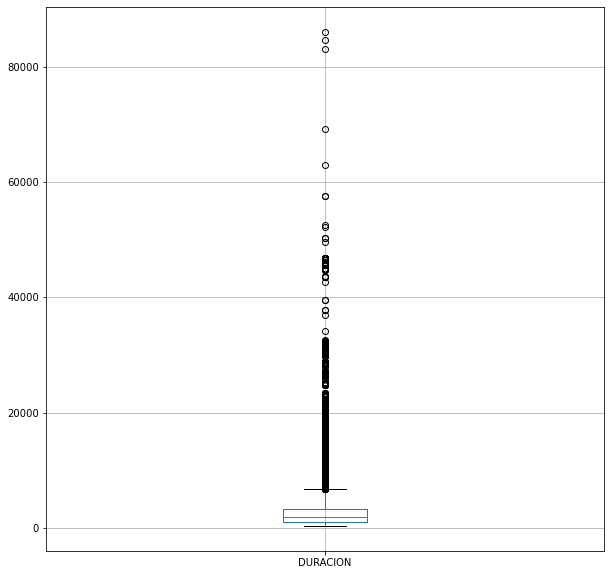

In [202]:
df.boxplot(column=['DURACION'], figsize=(10,10), grid=True)

Ya con el CSV preparado, tenemos las siguientes variables con las cuales trabajar:

In [203]:
columnas = np.array(df.columns)
print(pd.Series(columnas))
print(f"Hay {len(columnas)} columnas")

0             EMPRESA
1          ID_EMPRESA
2       TIPO_OPERADOR
3                ANNO
4           TRIMESTRE
5               FECHA
6         HORA_INICIO
7            HORA_FIN
8            DURACION
9            PROGRAMA
10      CLASIFICACION
11             GENERO
12               TIPO
13     CLOSED_CAPTION
14       LENGUA_SENAS
15        SUBTITULADO
16    LENGUAS_NATIVAS
17            JORNADA
dtype: object
Hay 18 columnas


A continuacion se describira cada una de las variables con los respectivos valores que puede adoptar.

### EMPRESA:

Nombre de los concesionarios o licenciatarios.

In [204]:
empresas = df["EMPRESA"].unique()
print(pd.Series(empresas))
print(f"Hay {len(empresas)} empresas")

0                  Asociación Comunidad De Restauración
1     Asociación De Televidentes De La Estación Loca...
2                   Fundación Para El Desarrollo Social
3          Fundación Para El Desarrollo Social Promover
4                                         Canal Capital
5                                       Teveandina Ltda
6             Television Regional Del Oriente Canal Tro
7                             Plural Comunicaciones Sas
8                              Universidad Del Pacífico
9                                Caracol Television S.A
10                                            Ceettv Sa
11           Fundacion Magdalena Medios De Comunicación
12                                  Rcn Television S.A.
13           Radio Televisión Nacional De Colombia Rtvc
14                                      Fundación Ictus
15            Sociedad Televisiòn De Antioquia Limitada
16    Sociedad De Television De Caldas Risaralda Y Q...
17            Canal Regional Del Caribe Telecari

### ID_EMPRESA:
Número de identificación tributario de los concesionarios o licenciatarios.

In [205]:
ids = df["ID_EMPRESA"].unique()
print(print(pd.Series(ids)))
print(f"Hay {len(ids)} ids") 

0            800214261
1            900039384
2            805024229
3            830012587
4            830005370
5            807000294
6            901032662
7            835000300
8            860025674
9            900163045
10           829002093
11           830029703
12           900002583
13           830080615
14           890937233
15           890807724
16           890116965
17         811006762-3
18           890331524
19           829001133
20           891800234
21           891200935
22           812008353
23           804006381
24           890399010
25           800118954
26           811006762
27    Nit. 900039384-7
28           860063952
29          8901169650
dtype: object
None
Hay 30 ids


### TIPO_OPERADOR:

Modalidad bajo la cual el concesionario y/o licenciatario presta el servicio de televisión.

In [206]:
operadores = df["TIPO_OPERADOR"].unique()
print(print(pd.Series(operadores)))
print(f"Hay {len(operadores)} tipos de operador") 

0        Tv Sin Animo De Lucro - Local Abierta
1                Tv Pública - Regional Abierta
2                Tv Privada - Nacional Abierta
3                   Tv Privada - Local Abierta
4                Tv Pública - Nacional Abierta
5    Concesión Espacios De Tv Abierta Nacional
dtype: object
None
Hay 6 tipos de operador


### ANNO:

Corresponde al año para el cual se reporta la información.

In [207]:
annos = df["ANNO"].unique()
print(print(pd.Series(annos)))
print(f"Hay {len(annos)} años") 

0    2020
1    2019
2    2021
3    2022
dtype: object
None
Hay 4 años


### TRIMESTRE:
Corresponde al trimestre del año para el cual se reporta la información.

In [208]:
trimestre = df["TRIMESTRE"].unique()
print(print(pd.Series(trimestre)))
print(f"Hay {len(trimestre)} trimestres activos") 

0    2
1    1
2    3
3    4
dtype: object
None
Hay 4 trimestres activos


### FECHA:
Fecha de emisión del espacio institucional.

In [209]:
fecha = df["FECHA"].unique()
print(print(pd.Series(fecha)))
print(f"Hay {len(fecha)} fechas") 

0       2020-04-01
1       2020-04-02
2       2020-04-03
3       2020-04-04
4       2020-04-05
           ...    
1000    2022-03-27
1001    2022-03-28
1002    2022-03-29
1003    2022-03-30
1004    2022-03-31
Length: 1005, dtype: object
None
Hay 1005 fechas


### PROGRAMA:
Nombre del programa.

In [210]:
programas = df["PROGRAMA"].unique()
print(print(pd.Series(programas)))
print(f"Hay {len(programas)} programas") 

0                Huellas Del Amado
1                           Plan B
2                 Desde El Púlpito
3             Mensaje De Esperanza
4        El Puede Hacerlo De Nuevo
                   ...            
55200                 Entre Libros
55201      Franja Foros Educaticos
55202    Entrevista Con La Ciencia
55203           Charlas Con Aguayo
55204               Salud Univalle
Length: 55205, dtype: object
None
Hay 55205 programas


### CLASIFICACION:
Clasificación de la programación acorde con el artículo 25 del acuerdo 002 de 2011.

In [211]:
classif = df["CLASIFICACION"].unique()
print(print(pd.Series(classif)))
print(f"Hay {len(classif)} clasificaciones")

0       Familiar
1       Infantil
2    Adolescente
3         Adulto
4             Nd
dtype: object
None
Hay 5 clasificaciones


### GENERO:
Género del contenido emitido

In [212]:
generos = df["GENERO"].unique()
print(print(pd.Series(generos)))
print(f"Hay {len(generos)} generos")

0     No Ficción
1        Ficción
2    Informativo
3       Infantil
4             Nd
dtype: object
None
Hay 5 generos


### TIPO:
Tipo del contenido emitido según la clasificación interna del operador.

In [213]:
tipos = df["TIPO"].unique()
print(pd.Series(tipos))
print(f"Hay {len(tipos)} tipos de programa.")

0                  Educativo
1                Predicación
2                    Musical
3                Testimonial
4                 Variedades
               ...          
612        Cultural Historia
613     Cultural Entrevistas
614    Magazin Universitario
615        Programa De Salud
616       Entrevista Musical
Length: 617, dtype: object
Hay 617 tipos de programa.


### CLOSED_CAPTION:
Tipo de sistema de generación de texto escondido o closed caption (CC) que tiene implementado el programa.

In [214]:
closed_c = df["CLOSED_CAPTION"].unique()
print(print(pd.Series(closed_c)))
print(f"Hay {len(closed_c)} tipos de closed caption")

0                     Ninguno
1                          Nd
2        Transcripción Manual
3    Transcripción Automática
dtype: object
None
Hay 4 tipos de closed caption


|LENGUA_SENAS | SUBTITULADO | LENGUAS_NATIVAS |
|-------------|-------------|-----------------|
|El programa tiene lengua de señas colombiana (LSC).|El programa incluye algún tipo de subtitulación visible.|En alguna parte del programa aparecen lenguas nativas, étnicas o criollas.|


In [215]:
señas_sub_nat = np.array(list(set(df["LENGUA_SENAS"])))
print(señas_sub_nat)
print(f"Hay {len(señas_sub_nat)} tipos de opcion para lengua de señas, subtitulado y lenguas nativas")

['No' 'Si' 'Nd']
Hay 3 tipos de opcion para lengua de señas, subtitulado y lenguas nativas


## Graficos

Frecuencias de señas:


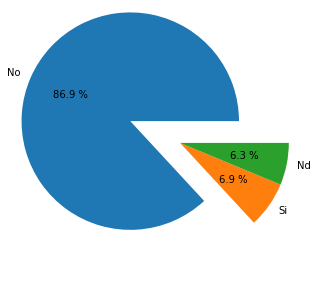

No    749573
Si     59129
Nd     54035
Name: LENGUA_SENAS, dtype: int64


In [216]:
freq_s = df["LENGUA_SENAS"].value_counts()
print(f"Frecuencias de señas:")
explode = (0.5, 0, 0) 
plt.figure(figsize=(5,5))
plt.pie(freq_s, explode=explode,labels=freq_s.index, autopct="%0.1f %%" )
plt.show()
print(freq_s)

Frecuencias de subtitulado:


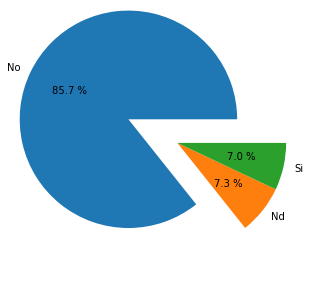

No    739423
Nd     62715
Si     60599
Name: SUBTITULADO, dtype: int64


In [217]:
freq_sb = df["SUBTITULADO"].value_counts()
print(f"Frecuencias de subtitulado:")
explode = (0.5, 0, 0) 
plt.figure(figsize=(5,5))
plt.pie(freq_sb,explode = explode,labels=freq_sb.index, autopct="%0.1f %%")
plt.show()
print(freq_sb)

Frecuencias de  nativas:


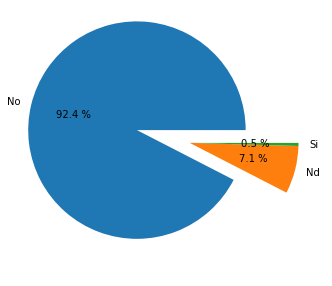

No    797511
Nd     61326
Si      3900
Name: LENGUAS_NATIVAS, dtype: int64


In [218]:
freq_nt = df["LENGUAS_NATIVAS"].value_counts()
print(f"Frecuencias de  nativas:")
explode = (0.5, 0, 0) 
plt.figure(figsize=(5,5))
plt.pie(freq_nt,explode = explode, labels=freq_nt.index, autopct="%0.1f %%")
plt.show()
print(freq_nt)

## Dkan API

In [35]:
def DkanLecture(campo=None, busquedas=None):
    url = """https://postdata.gov.co/api/action/datastore/search.json?resource_id=1895fbee-42f5-41b5-bba7-a2d03cb0f723"""
        
    if busquedas == None:
        pass
    else:
        url += f"&limit={busquedas}"
    
    if campo == None:
        pass
    else:
        url += f"&fields[]={campo}"

    js = requests.get(url)
    print("Hola")
    print(js)
    js = json.loads(js.content)
    
    df = pd.json_normalize(js["result"]["records"])
    
    return df

In [36]:
set(DkanLecture(campo = "programa", busquedas = 1000)["programa"])

Hola
<Response [200]>


{'180 GRADOS',
 'ANIMADOS ABN',
 'AVIVAMIENTO ABN',
 'BAYLESS CONLEY',
 'CAFÉ CON DIOS',
 'CINE ABN ',
 'CLUB 700 HOY',
 'CONCIERTOS ABN',
 'CORNERSTONE EN ESPAÑOL',
 'DESDE EL PÚLPITO',
 'DOMINGO FAMILIAR ',
 'DOMINGO FAMILIAR (REPETICIÓN)',
 'EL AMOR QUE VALE',
 'EL CAMPEÓN QUE HAY EN TI',
 'EL PUEDE HACERLO DE NUEVO',
 'EN CONTACTO',
 'ES SOBRENATURAL',
 'HUELLAS DEL AMADO',
 'JOYCE MEYER',
 'JUSTO A TIEMPO',
 'LA VOZ DE VICTORIA',
 'LOS PASOS DEL MAESTRO',
 'MENSAJE DE ESPERANZA',
 'MUNDO CRISTIANO',
 'MUSICA ABN',
 'NOTICIERO DEL SENADO',
 'PELICULA ABN ',
 'PLAN B',
 'PROGRAMA DEFENSOR DEL TELEVIDENTE',
 'RANDY MORRISON',
 'SIN MITÓMANOS',
 'SUPERLIBRO',
 'TIEMPOS DE ALABAR',
 'VIDA DURA',
 'VIERNES DE MILAGROS',
 'VIERNES DE MILAGROS (REPETICIÓN)',
 'VIVE +',
 'VIVE MAS',
 'VIVE MAS '}